# PP275 Spatial Data & Analysis

### Anaya Hall


## Research Question
In 2016, California’s Governor Brown signed into law the Short-Lived Climate Pollutant Bill (SB 1383), which targets anthropogenic methane emissions as part of the State’s overall climate change mitigation policy portfolio. This law requires reductions in the amount of organic fraction of municipal solid waste disposal by 50% in the year 2020 and 75% in the year 2025. CalRecycle, the agency in charge of resource reuse and recovery, anticipates that composting facilities will handle the bulk of this material, but at present there are only enough facilities to handle about half of the organic feedstock that will be generated going forward. State policy-makers expect that 50-100 new composting facilities will need to be built to meet the requirements of SB1383. Where should these new facilities be sited, given social, environmental and economic constraints, in order to maximize efficiency? 

### Anticipated Data Sources
County-level biomass resources in bone-dry tonnes, by feedstock type (here, focusing on food scraps and green waste) (already acquired from LBNL scientist Dr. Breunig)
County-level population-weighted centroids (US Census)
Existing composting facilities with information on capacity, accepted feedstock, permit type, and location (CalRecycle’s Solid Waste Inventory System)
Road network with type of road and speed limit (from OpenStreetMap)
Jurisdictional zones: Air Quality Management Districts and Water Quality Management Districts which limit where new solid waste facilities can be sited (CalEPA)
Environmental justice scores (shapefile from CalEPA)
Sites of potential end-use for compost (ie, rangelands and cultivated croplands) (from California Natural Resources Agency)
Series of emission factors for processing compost and roadway travel

### Analysis Plan
This research will combine biomass-generation, existing processing facilities, and potential compost end-use locations via California’s road network to identify optimal siting locations for new compost facilities in the State. The analysis will assign biomass resources targeted by SB1383 to population-weighted county centroids and map these in relation to existing composting facilities. A spatial optimization will be run to evaluate where and what size of composting facilities to build within boundary zones identified as potential sites of new facilities with the objective of minimizing cost of transport, minimizing GHG-emissions in EJ communities, or maximizing resource use (TBD). The road network will be used to connect these nodes of generation and (potential) processing to calculate edge distance, and solve for the given objective.


# Plan (like a lab!)
First, read in input data: CA shapefile, road network (OSM API?), existing processing facilities, biomass generation points, rangelands for application
constraints data: jurisdictions, zoned areas, EJ score

Present above data in series of maps and histograms

Second, optimization under diffrent different objectives:
(use djistkra's algorithim to calculate shortest distance)
shortest road travel (minimizing emissions), cost?, sites of interest, maximizing feedstock use. 
(**see recent lab with djistkra's**)

Method: generate random locations of potential new sites (**see hawaii lab**)(under a constraint of distance to existing facility? and appropriate zones) and for those sites calculate amount of feedstock and land area within certain radius, OR for all pixels in potential site, calculate within range and choose those 50-100 with best

Finally, present series of plots showing potential locations under the three policy objectives, and compare by cost?


In [111]:
#import packages
import pickle
from os.path import join as opj
import numpy as np
import pandas as pd
import geopandas as gpd
# import shapely?
import matplotlib.pyplot as plt
%matplotlib inline

# set data directory
DATA_DIR = "/Users/anayahall/projects/compopt/data"

### Data used in this script:
california_counties_shapefile = "raw/CA_Counties/CA_Counties_TIGER2016.shp"
# cal_tracts_shapefile = "/Users/anayahall/Box Sync/data/tl_2019_06_tract/tl_2019_06_tract.shp"
msw_shapefile = "msw_2020/msw_2020.shp"
roads_shapefile = "/Users/anayahall/Box Sync/data/tl_2019_06_prisecroads/tl_2019_06_prisecroads.shp"
compost_facilities_shapefile = "clean/clean_swis.shp" # note: PREVIOUSLY CLEANED!

### Data Sources

#### California Counties and Demographics
Census, TigerLine; 
Roads (primary and secondary)

#### MSW Biomass
From JBEI's Biositing Webtool, developed at LBNL
https://biositing.jbei.org/info/about

#### Existing Composting Facilities
CalRecycle's Solid Waste Inventory System (SWIS)

In [ ]:
# simulating random points:


# # FROM HAWAII LAB
# # number of events to simulate
# N = 1000
# # AREA to cast random numbers in 
# # 7 degrees from -161
# lon = np.random.random(N) * 7 - 161
# # 4 degrees from 18.5
# lat = np.random.random(N) * 4 + 18.5
# # this reorganizes the points such that the input format
# # is consistent with what MultiPoint() expects
# emergency_events = MultiPoint(np.vstack((lat, lon)).T)


# could simulate in square across state then keep only ones that intersect with the state

In [112]:
# load data

# California counties
california = gpd.read_file(opj(DATA_DIR, 
        california_counties_shapefile))
# set to convention for california 4326 (so all in degrees!)
california = california.to_crs(epsg=4326)

# Municipal Solid Waste
msw = gpd.read_file(opj(DATA_DIR,
                  msw_shapefile))
# filter to just keep food and green waste (subject of regulations)
msw = msw[(msw['subtype'] == "MSWfd_wet_dryad_wetad") | (msw['subtype'] == "MSWgn_dry_dryad")]

# data notes: 
# fog = Fats, Oils, Grease; lb = lumber; cd = cardboard; fd = food;
# pp = paper, gn = green; ot = Other ; suffix describes what the 
# waste is deemed suitable for


# rename categories to be more intuitive
msw['subtype'].replace({'MSWfd_wet_dryad_wetad': 'MSW_food', 
                        'MSWgn_dry_dryad': 'MSW_green'}, inplace = True)

# Roads
road_network = gpd.read_file(roads_shapefile)

# Composting Facilities
composters = gpd.read_file(opj(DATA_DIR,
                                compost_facilities_shapefile))

# Rangelands

# EJ



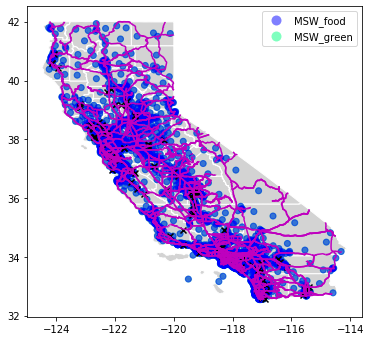

In [125]:
fig, ax = plt.subplots(figsize = (6,6))
# for geom in california['geometry']: 
#     if geom.type == 'Polygon':
#         # plot normally
# #         plt.plot(*df.loc[d, 'geometry'].exterior.xy, 'w-', linewidth =1.5)
#         lat, lon = geom.exterior.xy
# #         plt.plot(lat, lon, 'k--')
#         ax.plot(*geom.exterior.xy, 'darkgrey', linewidth = 1.5)
#     elif geom.type == 'MultiPolygon':
#         for p in geom:
#             ax.plot(*p.exterior.xy, 'darkgrey', linewidth =1.5)
california.plot(color = 'lightgrey', edgecolor = 'white', ax = ax)
msw.plot(column = 'subtype', legend = True, ax = ax, alpha = 0.5, cmap = 'winter')
composters.plot(marker = 'x', color = 'k', legend = True, ax = ax)
road_network.plot(color = 'm', legend = True, ax = ax)

In [124]:
msw.groupby(['County', 'subtype']).sum()

bdt             wt  wetad  dryad  wood  cellulosic
County  subtype                                                               
Alameda MSW_food   43943.860567  199744.820761  360.0  360.0   0.0         0.0
        MSW_green  94767.645348  194438.523015    0.0  360.0   0.0       360.0
Alpine  MSW_food      55.157417     250.715533    1.0    1.0   0.0         0.0
        MSW_green    118.950372     244.055178    0.0    1.0   0.0         1.0
Amador  MSW_food    1020.981601    4640.825459    9.0    9.0   0.0         0.0
...                         ...            ...    ...    ...   ...         ...
Ventura MSW_green  66176.311820  135776.554135    0.0  173.0   0.0       173.0
Yolo    MSW_food    6743.642717   30652.921441   41.0   41.0   0.0         0.0
        MSW_green  14543.081402   29838.614831    0.0   41.0   0.0        41.0
Yuba    MSW_food    5553.401795   25242.735431   14.0   14.0   0.0         0.0
        MSW_green  11976.253451   24572.152486    0.0   14.0   0.0        14.0

[114 rows x 6 columns]